In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl

width, height = 10, 5
mpl.rcParams['figure.figsize'] = [width, height]

In [2]:
from sklearn import svm
from sklearn import pipeline
from sklearn import preprocessing
from sklearn import model_selection

from utility_fns import form_last_n_games
from utility_fns import make_train_val_test


In [3]:

basedir = os.path.dirname(os.getcwd())
data = os.path.join(basedir, 'data','derived','cleaned_matches.csv')
cleaned_matches = pd.read_csv(data)

In [4]:
cleaned_matches.Date = pd.to_datetime(cleaned_matches.Date)
cleaned_matches.sort_values(by='Date',inplace=True,ascending=True)
cleaned_matches.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26122 entries, 0 to 26121
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Day             26122 non-null  object        
 1   Date            26122 non-null  datetime64[ns]
 2   Home/Away       26122 non-null  object        
 3   Opponent        26122 non-null  object        
 4   Score           26122 non-null  object        
 5   W/L/T           26122 non-null  object        
 6   Overtime        948 non-null    object        
 7   Location        26122 non-null  object        
 8   Venue           26122 non-null  object        
 9   Attendance      26098 non-null  float64       
 10  Notes           1061 non-null   object        
 11  Opponent Code   26122 non-null  object        
 12  Team            26122 non-null  object        
 13  Team Code       26122 non-null  object        
 14  Team Score      25942 non-null  float64       
 15  Op

## Train to classify based on the last-n-games a team played

In [5]:
x_cols = [
  'Team Code',
  'Opponent Code',
]
y_cols = [
  'Class'
]
played_matches = cleaned_matches.dropna(axis=0, how='any', subset=x_cols + y_cols)

played_matches['Class'].where(played_matches['Class'] < 1, other=0, inplace=True)

last_n_matches, new_columns = form_last_n_games(played_matches, 5, ['Class'])

c:\Users\Eric\Documents\Cornell\Coursework\ORIE 4741\ORIE4741_Project\models\utility_fns.py:10: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "form_last_n_games" failed type inference due to: Untyped global name 'deque': Cannot determine Numba type of <class 'type'>

File "utility_fns.py", line 34:
def form_last_n_games(df: pd.DataFrame, n: int, cols_to_grab=['Class'], lookup_cols=['Team Code']):
    <source elided>
            lkup_key = row[lookup]
            last_n = lookup_dict.get(lkup_key, deque(maxlen=n))
            ^

  @jit
c:\Users\Eric\Documents\Cornell\Coursework\ORIE 4741\ORIE4741_Project\models\utility_fns.py:10: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "form_last_n_games" failed type inference due to: Cannot determine Numba type of <class 'numba.core.dispatcher.LiftedLoop'>

File "utility_fns.py", line 28:
def form_last_n_games(df: pd.DataFrame, n: int, c

.................................................
 Done


In [6]:

X = pd.concat([pd.get_dummies(last_n_matches[xcol],prefix='_'.join(xcol.split())+'_') for xcol in x_cols] + [last_n_matches[new_columns]], axis=1)
y = last_n_matches[y_cols]


In [7]:
X.head()

,Team_Code__ari,Team_Code__atl,Team_Code__bal,Team_Code__buf,Team_Code__chib,Team_Code__chic,Team_Code__cin,Team_Code__cle,Team_Code__dal,Team_Code__den,...,Opponent_Code__sea,Opponent_Code__sf,Opponent_Code__stl,Opponent_Code__tb,Opponent_Code__was,Team Code_p_Class,Team Code_pp_Class,Team Code_ppp_Class,Team Code_pppp_Class,Team Code_ppppp_Class
25,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0
29,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0
31,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0
32,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,-1.0,-1.0,0.0,0.0,0.0
33,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0


In [8]:
y.head()

,Class
25,0
29,0
31,0
32,-1
33,0


In [9]:
y=y.dropna()
X=X.dropna()

In [10]:
X_train, X_val, X_test, y_train, y_val, y_test = make_train_val_test(
  X.to_numpy(), y.to_numpy(), test_pct = 0.2, val_pct=0.2, random_state=0
)

y_train=y_train.ravel()
y_val=y_val.ravel()
y_test=y_test.ravel()

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(15579, 67) (15579,)
(5194, 67) (5194,)
(5194, 67) (5194,)


Evaluating linear kernel for C=0.01
Evaluating linear kernel for C=0.03760603093086394
Evaluating linear kernel for C=0.1414213562373095


C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\svm\_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


Evaluating linear kernel for C=0.5318295896944989


C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\svm\_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


Evaluating linear kernel for C=2.0


C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\svm\_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


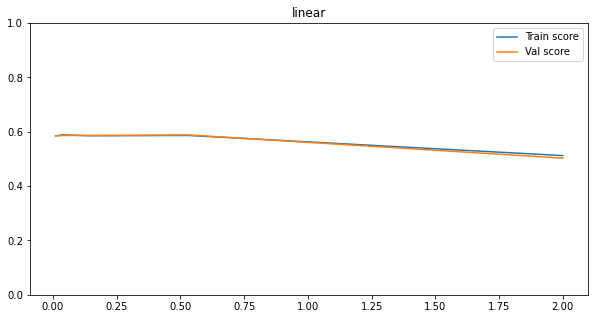

In [11]:
for kernel in ['linear']: #, 'poly','rbf','sigmoid']:
  train_scores = []
  val_scores = []
  val_space = np.geomspace(start=0.01, stop=2, num=5)
  for C in val_space:
    print(f"Evaluating {kernel} kernel for C={C}")
    model = pipeline.make_pipeline(
      # preprocessing.MinMaxScaler(),
      svm.SVC(C=C,max_iter=10_000,kernel=kernel),
    )

    model.fit(X_train, y_train)
    train_scores.append(model.score(X_train, y_train))
    val_scores.append(model.score(X_val, y_val))

  plt.title(kernel)
  plt.plot(val_space, train_scores, label='Train score')
  plt.plot(val_space, val_scores, label='Val score')
  plt.ylim(0, 1)
  plt.legend()
  plt.show()

In [12]:
model.decision_function(X_test[0:1])

array([0.47222263])

In [13]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier

best_config = []
best_score = 0
best_fit_config = []
best_fit_score = 0
for estimator in [DecisionTreeClassifier(max_leaf_nodes=3), DecisionTreeClassifier(max_leaf_nodes=5), DecisionTreeClassifier(max_leaf_nodes=62), DecisionTreeClassifier(max_leaf_nodes=124)]:
  for nestimators in [10, 31, 62, 93, 124]:
    for nsamples in [10, 20, 30, 50]:
      regressor = BaggingRegressor(base_estimator=estimator, n_estimators=nestimators, max_samples=nsamples)
      regressor.fit(X_train, y_train)
      
      score = regressor.score(X_val, y_val)
      if(score > best_score):
        best_config = [estimator, nestimators, nsamples]
        best_score = score
      
      score = regressor.score(X_train, y_train)
      if(score > best_fit_score):
        best_fit_config = [estimator, nestimators, nsamples]
        best_fit_score = score
        
      print(end='.')

................................................................................

In [14]:
print(f"Best validation: {best_score}, {best_config}")
print(f"Best training: {best_fit_score}, {best_fit_config}")

Best validation: 0.03630920113653635, [DecisionTreeClassifier(max_leaf_nodes=3), 93, 50]
Best training: 0.033751269123488914, [DecisionTreeClassifier(max_leaf_nodes=124), 124, 50]


In [15]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
clf.score(X_val, y_val)

0.5288794763188294

In [16]:
clf.predict_proba(X_test[0:1])

array([[0.5, 0.5]])

In [17]:
team_opponent_codes = X.columns[:-5]
n_team_codes = len(team_opponent_codes) // 2
opponent_codes, team_codes = team_opponent_codes[n_team_codes:], team_opponent_codes[:n_team_codes]
print(n_team_codes)
print(opponent_codes)
print(team_codes)

31
Index(['Opponent_Code__ari', 'Opponent_Code__atl', 'Opponent_Code__bal',
       'Opponent_Code__buf', 'Opponent_Code__chib', 'Opponent_Code__chic',
       'Opponent_Code__cin', 'Opponent_Code__cle', 'Opponent_Code__dal',
       'Opponent_Code__den', 'Opponent_Code__det', 'Opponent_Code__gb',
       'Opponent_Code__hou', 'Opponent_Code__ind', 'Opponent_Code__kc',
       'Opponent_Code__larm', 'Opponent_Code__mia', 'Opponent_Code__min',
       'Opponent_Code__ne', 'Opponent_Code__no', 'Opponent_Code__nyg',
       'Opponent_Code__nyj', 'Opponent_Code__oak', 'Opponent_Code__phi',
       'Opponent_Code__pit', 'Opponent_Code__sd', 'Opponent_Code__sea',
       'Opponent_Code__sf', 'Opponent_Code__stl', 'Opponent_Code__tb',
       'Opponent_Code__was'],
      dtype='object')
Index(['Team_Code__ari', 'Team_Code__atl', 'Team_Code__bal', 'Team_Code__buf',
       'Team_Code__chib', 'Team_Code__chic', 'Team_Code__cin',
       'Team_Code__cle', 'Team_Code__dal', 'Team_Code__den', 'Team_Code__det'

In [18]:
teams = X[team_codes]
opponents = X[opponent_codes]

codes = team_codes.str.split('__')
teams.columns = [code[1] for code in codes]

codes = opponent_codes.str.split('__')
opponents.columns = [code[1] for code in codes]

<AxesSubplot:>

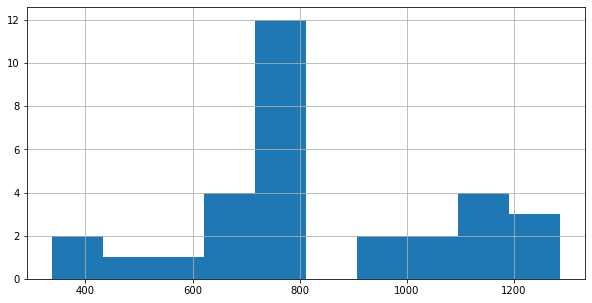

In [19]:
teams.sum(axis=0).hist()

<AxesSubplot:>

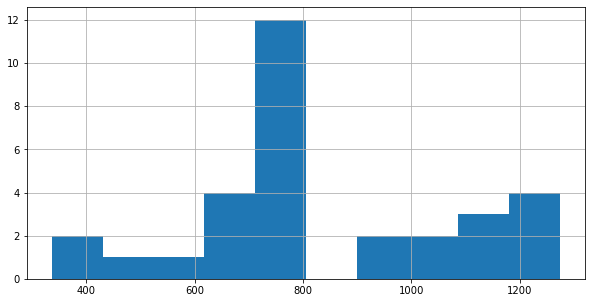

In [20]:
opponents.sum(axis=0).hist()

<AxesSubplot:>

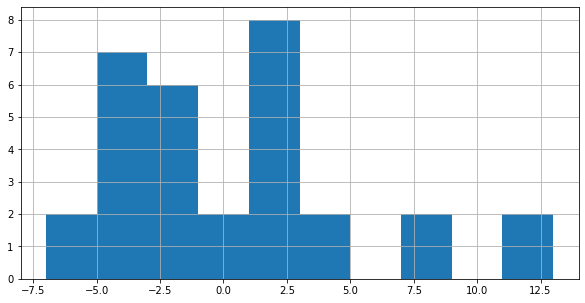

In [21]:
(teams.sum(axis=0) - opponents.sum(axis=0)).hist()

In [22]:
unique_teams = X.groupby(team_opponent_codes.to_list()).size().reset_index(name="Count").sort_values('Count').reset_index(drop=True)

In [23]:
unique_teams

,Team_Code__ari,Team_Code__atl,Team_Code__bal,Team_Code__buf,Team_Code__chib,Team_Code__chic,Team_Code__cin,Team_Code__cle,Team_Code__dal,Team_Code__den,...,Opponent_Code__oak,Opponent_Code__phi,Opponent_Code__pit,Opponent_Code__sd,Opponent_Code__sea,Opponent_Code__sf,Opponent_Code__stl,Opponent_Code__tb,Opponent_Code__was,Count
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
901,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,177
902,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,177
903,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,177
904,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,198


In [24]:
for _, row in unique_teams.iterrows():
    mask = row > 0
    elements = row[mask]
    print(' '.join([elem.split('__')[1] for elem in elements.index[:-1]]), elements[-1])


no no 1.0
kc kc 1.0
stl chic 1.0
ne ne 1.0
sea chic 1.0
chic bal 1.0
sd chic 1.0
tb chic 1.0
sf chic 2.0
chic kc 2.0
kc chic 2.0
chic sf 2.0
buf chic 3.0
cin chic 3.0
ind larm 3.0
larm ind 3.0
oak larm 4.0
larm oak 4.0
chic cin 4.0
chic buf 4.0
ind stl 5.0
ind ari 5.0
buf ari 5.0
hou ari 5.0
ari ind 5.0
sd larm 5.0
ari hou 5.0
chic min 5.0
ari buf 5.0
stl ind 6.0
oak stl 6.0
kc larm 6.0
stl oak 6.0
larm sd 6.0
nyj ari 6.0
larm kc 6.0
mia ari 6.0
ari nyj 6.0
ari cle 6.0
ne ari 6.0
ari mia 6.0
min chic 6.0
ari ne 6.0
bal ari 7.0
cle ari 7.0
hou stl 7.0
den ari 7.0
oak ari 7.0
larm buf 7.0
tb bal 7.0
mia larm 7.0
ari oak 7.0
larm mia 7.0
ari bal 7.0
buf larm 7.0
ind min 7.0
min ind 7.0
ari den 7.0
ari sd 7.0
sd ari 7.0
stl hou 7.0
bal sea 8.0
stl den 8.0
ari larm 8.0
bal tb 8.0
pit ari 8.0
larm ne 8.0
larm nyj 8.0
oak was 8.0
ari kc 8.0
den stl 8.0
nyj larm 8.0
hou larm 8.0
kc phi 8.0
ari cin 8.0
larm cin 8.0
larm den 8.0
larm hou 8.0
den larm 8.0
kc ari 8.0
nyg ind 8.0
ind nyg 8.0
ari pi